<h1 align="center">AIND-CNC Spring Hackathon</h1>  
<h4 align="center"> May 14, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** This notebook shows how to access and analyze data from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) project established at the Allen Institute for Neural Dynamics. 

**Dataset:** Calcium activity was recorded from hundreds of cortical neurons in the mouse brain while the animal learned and performed a Brain Computer Interface (BCI) task over several days. A 2p microscope was used to record cellular Ca2+ activity in transgenic animals from a single plane FOV in motor cortex. 
    
**Goal:** This tutorial will show you how to:  
    1. load and work with neuronal calcium activity data processed via suite2p 
    2. plot event-aligned neural activity traces 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [8]:
# general imports 
import matplotlib.pyplot as plt
import numpy as np

# pynwb imports to open nwb files
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [3]:
nwb_file = '/data/nwb/single-plane-ophys_767715_2025-02-17_17-41-50_behavior_nwb'

with NWBZarrIO(nwb_file, "r") as io:
    nwbfile_read = io.read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [9]:
nwb2widget(nwbfile_read) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### 1. Plot Calcium Activity Traces for Select ROIs 
    
The raw data was processed through Suite2p, which extracts the cell body ROIs and calculates the change in fluorescence (dff). Let's pull that data from the nwb file below. The shape of roi_dff is (frames, roi). 
    
We'll also save the frame_rate so we can easily convert from frames to seconds. 
    

In [20]:
roi_dff = nwbfile_read.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('roi_dff shape:',np.shape(roi_dff))

frame_rate = nwbfile_read.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].rate
print('Frame Rate:', frame_rate)

roi_dff shape: (238556, 564)
Frame Rate: 58.2262


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The roi_dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons (pre) - spont_slm * 
    2. Spontaneous activity (pre) - spont *
    3. BCI behavior task - BCI 
    4. Spontaneous activity (post) - spontpost * 
    5. Photostimulation of random single neurons (post) -spontpost_slm * 
    

The stimulus tables in the stimulus>PhotostimTrials and the behavior table in the intervals>trials containers contains the start/stop times for each epoch. 

*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

Text(0, 0.5, '$\\Delta$ F/F')

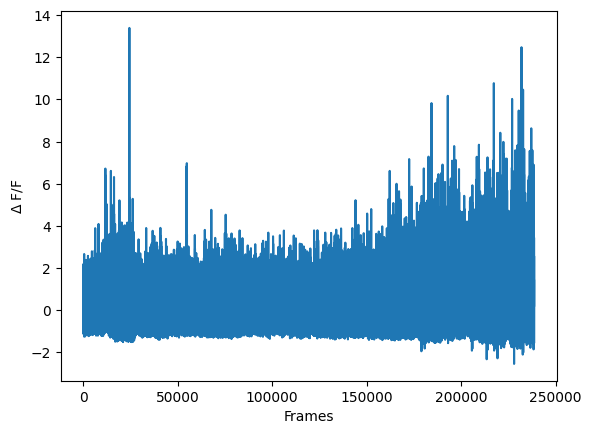

In [21]:
# Plot calcium activity trace for select ROIs 

ROI = 1 

plt.plot(roi_dff[:,ROI])
plt.xlabel('Frames') 
plt.ylabel('$\Delta$ F/F')

to do: 

    metadata - identify relevant metadata to pull 
    
    relate ROIs in dff to ROI masks 
    
    plot ROIs with stimulus epochs overlaid - do this programmatically pulling from tables 
    
    PSTH/event aligned neural activity
    
        - opto stim 
        
        - BCI (q: which event? motor movements?) 
        
    neural activity of each ROI organized by distance from stim neuron 
    
    nice to have: something to find connected neurons from stim periods, function to compare activity across several days 
    
    questions 